In [1]:
import pandas as pd
import numpy as np
import glob

import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt # cuz i can't fix the weird plotly bar plot, I have failed Professor Elzen :(

In [2]:
file_list = glob.glob("/Users/aniket/github/Exceptional_Model_Mining_2AMM20/pipeline/outputs/*/emm_all_languages_results_*.csv")

In [3]:
file_list = [x for x in file_list if "/old/" not in x]
file_list

['/Users/aniket/github/Exceptional_Model_Mining_2AMM20/pipeline/outputs/cmc/emm_all_languages_results_cmc.csv',
 '/Users/aniket/github/Exceptional_Model_Mining_2AMM20/pipeline/outputs/boston_housing/emm_all_languages_results_boston_housing.csv',
 '/Users/aniket/github/Exceptional_Model_Mining_2AMM20/pipeline/outputs/auto-mpg/emm_all_languages_results_auto-mpg.csv',
 '/Users/aniket/github/Exceptional_Model_Mining_2AMM20/pipeline/outputs/year_prediction_msd/emm_all_languages_results_year_prediction_msd.csv',
 '/Users/aniket/github/Exceptional_Model_Mining_2AMM20/pipeline/outputs/forestfires/emm_all_languages_results_forestfires.csv']

In [4]:
df = pd.DataFrame()
for file in file_list:
    dfx = pd.read_csv(file)
    name = file.split("_")[-1].split(".")[0]
    dfx["dataset"] = name
    df = pd.concat([df, dfx])

In [5]:
# df["dataset"]

In [6]:
df.to_csv("outputs/emm_all_results.csv", index=False)

In [7]:
# All Hail JBI100 and 2AMV10
df["ParetoLabel"] = np.where(df["pareto"], "Pareto", "Non-Pareto")

fig_scatter = px.scatter(
    df,
    x="complexity", y="q_residual",
    color="ParetoLabel",
    size="size",
    hover_data=[
        "rule","expr","operator","threshold","dataset","language",
        "size","mean_residual","q_signed","q_perm","p_value",
        "I_inv","I_exp","expressiveness","score"
    ],
    title="Quality vs Complexity (Pareto highlighted)",
)
fig_scatter.update_layout(xaxis_title="complexity", yaxis_title="q_residual", legend_title="")
fig_scatter.show()

fig_density = px.density_heatmap(
    df,
    x="complexity", y="q_residual",
    nbinsx=40, nbinsy=40,
    title="Result Density in (complexity, q_residual) Space",
)
fig_density.update_layout(xaxis_title="complexity", yaxis_title="q_residual")
fig_density.show()

color_map = {"Pareto": 1, "Non-Pareto": 0}
df["_pareto_num"] = df["ParetoLabel"].map(color_map)

parallel_dims = [
    dict(label="q_residual", values=df["q_residual"]),
    dict(label="q_signed", values=df["q_signed"]),
    dict(label="complexity", values=df["complexity"]),
    dict(label="size", values=df["size"]),
    dict(label="mean_residual", values=df["mean_residual"]),
    dict(label="expressiveness", values=df["expressiveness"]),
    dict(label="score", values=df["score"]),
]

fig_parallel = go.Figure(
    data=go.Parcoords(
        line=dict(
            color=df["_pareto_num"],
            colorscale=[[0, "lightgray"], [1, "blue"]],
            showscale=False,
        ),
        dimensions=parallel_dims,
    )
)
fig_parallel.update_layout(title="Parallel Coordinates of Metrics (Blue = Pareto, Gray = Non-Pareto)",
    # margin=dict(l=80, r=80, t=60, b=40)
    )
fig_parallel.show()

topN = 20
top_pareto = (
    df[df["pareto"]]
    .sort_values("q_residual", ascending=False)
    .head(topN)
    .copy()
)
top_pareto["label"] = (
    top_pareto["rule"].astype(str).str.slice(0, 100)
    + "  |  c=" + top_pareto["complexity"].astype(str)
    + "  n=" + top_pareto["size"].astype(str)
)
fig_bar = px.bar(
    top_pareto.iloc[::-1],
    x="q_residual",
    y="label",
    orientation="h",
    hover_data=["dataset","language","expr","operator","threshold","p_value","q_perm"],
    title=f"Top {min(topN, len(top_pareto))} Pareto Rules by q_residual",
)
fig_bar.update_layout(xaxis_title="q_residual", yaxis_title="")
fig_bar.show()

fig_ecdf = px.ecdf(
    df,
    x="q_residual",
    color="ParetoLabel",
    title="ECDF of q_residual (Pareto vs Non-Pareto)",
)
fig_ecdf.update_layout(xaxis_title="q_residual", yaxis_title="F(x)", legend_title="")
fig_ecdf.show()

fig_small = px.scatter(
    df,
    x="complexity", y="q_residual",
    color="ParetoLabel",
    size="size",
    facet_col="language",
    hover_data=["rule","expr","dataset","p_value","q_perm","I_inv","I_exp","expressiveness"],
    title="Quality vs Complexity by Language (Pareto highlighted)",
)
fig_small.update_layout(legend_title="", xaxis_title="complexity", yaxis_title="q_residual")
fig_small.show()

fig_3d = px.scatter_3d(
    df,
    x="complexity", y="size", z="q_residual",
    color="ParetoLabel",
    hover_data=["rule","expr","dataset","language","p_value","q_perm"], # P cool eh? Looked as pretty as on shark dataset
    title="3D View: (complexity, size, q_residual)",
)
fig_3d.show()


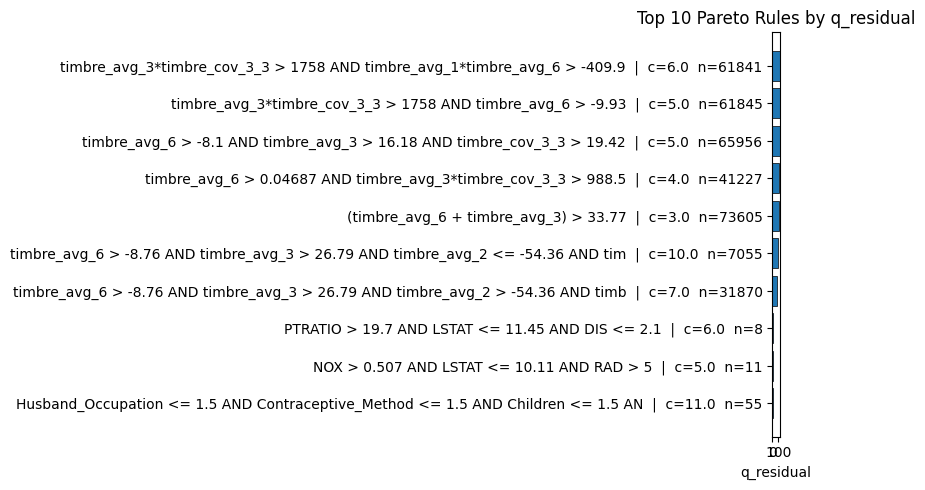

In [8]:
top10 = (
    df[df["pareto"]]
    .sort_values("q_residual", ascending=False)
    .head(10)
    .copy()
)

# Build readable labels (truncate rule text)
top10["label"] = (
    top10["rule"].astype(str).str.slice(0, 80)
    + "  |  c=" + top10["complexity"].astype(str)
    + "  n=" + top10["size"].astype(str)
)

# Plot horizontal bar chart
plt.figure(figsize=(8, 5))
plt.barh(
    range(len(top10)),
    top10["q_residual"],
    color="tab:blue",
    edgecolor="k",
    linewidth=0.5,
)
plt.yticks(range(len(top10)), top10["label"])
plt.xlabel("q_residual")
plt.title("Top 10 Pareto Rules by q_residual")
plt.gca().invert_yaxis()  # highest at top
plt.tight_layout()
plt.show()

/var/folders/3x/_h4mr3l14wdd2fz4hllvdbm80000gn/T/ipykernel_53599/3645933545.py:15: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.



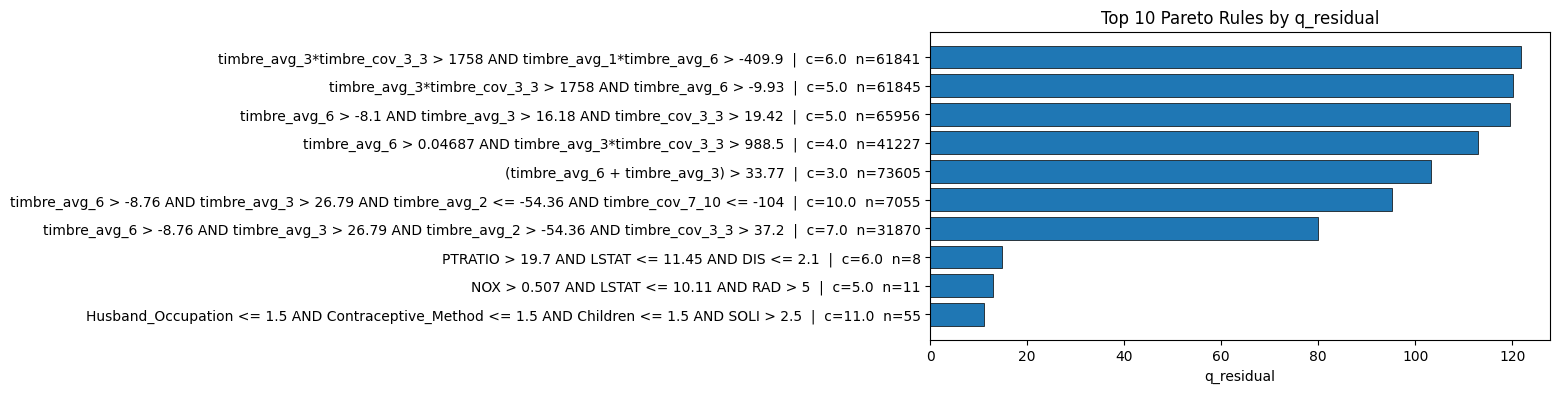

In [9]:
topN = 10
top_p = df[df["pareto"]].sort_values("q_residual", ascending=False).head(topN).copy()
labels_bar = (
    top_p["rule"].astype(str).str.slice(0, 100)
    + "  |  c=" + top_p["complexity"].astype(str)
    + "  n=" + top_p["size"].astype(str)
)
y = np.arange(len(top_p))
plt.figure(figsize=(8, max(4, 0.35*len(top_p))))
plt.barh(y, top_p["q_residual"], color="tab:blue", edgecolor="k", linewidth=0.5)
plt.yticks(y, labels_bar)
plt.xlabel("q_residual")
plt.title(f"Top {min(topN, len(top_p))} Pareto Rules by q_residual")
plt.gca().invert_yaxis()
plt.tight_layout()
